#Import Modules



In [1]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, Flatten

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers.schedules import ExponentialDecay

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler

#Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Import train400 Dataset

In [ ]:
# images = []
# for i in range(9):
#   image = tf.keras.preprocessing.image.load_img("/content/drive/MyDrive/train400/00{}.png".format(i+1))
#   input_arr = tf.keras.preprocessing.image.img_to_array(image)
#   img = np.divide(input_arr, 255.0)
#   images.append(img)

# for i in range(10, 99):
#   image = tf.keras.preprocessing.image.load_img("/content/drive/MyDrive/train400/0{}.png".format(i))
#   input_arr = tf.keras.preprocessing.image.img_to_array(image)
#   img = np.divide(input_arr, 255.0)
#   images.append(img)

# for i in range(100, 400):
#   image = tf.keras.preprocessing.image.load_img("/content/drive/MyDrive/train400/{}.png".format(i))
#   input_arr = tf.keras.preprocessing.image.img_to_array(image)
#   img = np.divide(input_arr, 255.0)
#   images.append(img)

In [ ]:
# images = np.array(images)
# print(images.shape)

In [3]:
base_url = "/content/drive/MyDrive/datas/"
folders = ["train400", "LIVE1", "LIVE1_q10", "LIVE1_q20", "LIVE1_q30", "LIVE1_q40", "BSD68"]

In [4]:
import subprocess
images = []
for folder in folders:
  output = subprocess.check_output("ls " + base_url + folder, shell=True)
  print(type(output))
  files_list = output.decode('utf-8').split('\n')
  files_list.pop()

  for image in files_list:
    image_real = tf.keras.preprocessing.image.load_img(base_url + folder + "/" +image)
    image_real = image_real.resize((300,300))
    input_arr = tf.keras.preprocessing.image.img_to_array(image_real)
    #  input_arr = input_arr.reshape((180,180,3))
    img = np.divide(input_arr, 255.0)
    images.append(img)

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


In [5]:
images = np.array(images)
print(images.shape)

(613, 300, 300, 3)


#ADD NOISE TO IMAGE

In [6]:
import numpy
noise_factor = 0.2
noisy_images = images + noise_factor * numpy.random.normal(loc=0.0, scale=1.0, size=images.shape)
# x_test_noisy = X_test + noise_factor * numpy.random.normal(loc=0.0, scale=1.0, size=X_test.shape)
x_train_noisy = numpy.clip(noisy_images, 0., 1.)
# x_test_noisy = numpy.clip(x_test_noisy, 0., 1.)

In [ ]:
# image_noisy = []
# for img in images:
#   image_noisy.append(noisy(img))

In [ ]:
# image_noisy = np.array(image_noisy)
# image_noisy.shape
# plt.imshow(images[0].reshape(300,300,3))
# print(type(images), type(image_noisy))
# print(images.shape, image_noisy.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


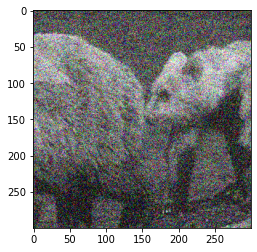

In [7]:
plt.imshow(noisy_images[0])

PSNR

In [8]:
from math import log10, sqrt
import cv2
import numpy as np
  
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr


# value1 = PSNR(noisy_images[7], reco1)

#CREATING TRAINING AND VALIDATION DATASET

In [9]:

train_images = images[0:500]
train_images_noisy = noisy_images[0:500]

val_images = images[500:613]
val_images_noisy = noisy_images[500:613]

print(train_images.shape, train_images_noisy.shape, val_images.shape, val_images_noisy.shape)

(500, 300, 300, 3) (500, 300, 300, 3) (113, 300, 300, 3) (113, 300, 300, 3)


#MODEL ARCHITECTURE

In [ ]:
input = layers.Input(shape=(300, 300, 3))

In [ ]:
# Encoder
def feature_extraction(input):
  # upper model
  x1 = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(input)
  x2 = layers.Conv2D(16, (3, 3), activation="relu", padding="same",dilation_rate=(2,2))(x1)

  # lower model
  y1 = layers.Conv2D(16, (3, 3), activation="relu", padding="same",dilation_rate=(2,2))(input)
  y2 = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(y1)

  # concat upper and lower model in feature extraction
  concatenated = tf.keras.layers.Concatenate(axis=-1)([x1, x2, y1, y2])

  return concatenated

In [ ]:
# Start of feature integration
def feature_integration(concatenated):
  conc_conv1 = layers.Conv2D(32, (1, 1), activation="sigmoid", padding="same")(concatenated)

  x3 = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(conc_conv1)
  x4 = layers.Conv2D(16, (3, 3), activation="relu", padding="same",dilation_rate=(2,2))(x3)

  # x4  = layers.Dropout(0.2)(x4)

  y3 = layers.Conv2D(16, (3, 3), activation="relu", padding="same",dilation_rate=(2,2))(conc_conv1)
  y4 = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(y3)

  # y4  = layers.Dropout(0.2)(y4)

  concatenated2 = tf.keras.layers.Concatenate(axis=-1)([x3, x4, y3, y4])

  print(concatenated2.shape)

  conc_conv2 = layers.Conv2D(16, (1, 1), activation="relu", padding="same")(concatenated2)

  concatenated3 = tf.keras.layers.Concatenate(axis=-1)([conc_conv1, conc_conv2])

  print(concatenated3.shape)

  return concatenated3

In [ ]:
# reconstruction
def reconstruction(concatenated3):
  x = layers.Conv2DTranspose(16, (3, 3), activation="relu", padding="same")(concatenated3)
  x = layers.Conv2DTranspose(16, (3, 3), activation="relu",  padding="same", dilation_rate=(2,2))(x)
  out = layers.Conv2D(3, (1, 1), activation="sigmoid", padding="same")(x)
  return out

In [ ]:
#making the ddfn model
model = feature_extraction(input)
for _ in range(1):
  model = feature_integration(model)
out_1 = reconstruction(model)

(None, 300, 300, 64)
(None, 300, 300, 48)


In [ ]:
model = feature_extraction(input)
for _ in range(2):
  model = feature_integration(model)
out_2 = reconstruction(model)

In [ ]:
model = feature_extraction(input)
for _ in range(3):
  model = feature_integration(model)
out_3 = reconstruction(model)

In [ ]:

model = feature_extraction(input)
for _ in range(4):
  model = feature_integration(model)
out_4 = reconstruction(model)

In [ ]:
model = feature_extraction(input)
for _ in range(5):
  model = feature_integration(model)
out_5 = reconstruction(model)

In [16]:
initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

In [ ]:
# running the model
import pickle
autoencoder1 = Model(input, out_1)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
autoencoder1.compile(optimizer=opt, loss="mse")
autoencoder1.summary()

# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history1 = autoencoder1.fit(x=train_images_noisy,y=train_images,epochs=100,batch_size=16,validation_data=(val_images_noisy, val_images))

filename = '1_layer.sav'
pickle.dump(history1.history, open(filename, 'wb'))

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 300, 300, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 300, 300, 16  448         ['input_1[0][0]']                
                                )                                                           

In [ ]:
with open('1_layer_history', 'wb') as file_pi:
        pickle.dump(history1.history, file_pi)

INFO:tensorflow:Assets written to: ram://52667aaf-0e50-47a5-ab2d-05753dd2248e/assets


In [ ]:
autoencoder2 = Model(input, out_2)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
autoencoder2.compile(optimizer=opt, loss="mse", metrics = ['accuracy'])
autoencoder2.summary()

# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history2 = autoencoder2.fit(x=train_images_noisy,y=train_images,epochs=100,batch_size=16,validation_data=(val_images_noisy, val_images))

filename = '2_layer.sav'
pickle.dump(autoencoder2, open(filename, 'wb'))

In [ ]:
with open('2_layer_history', 'wb') as file_pi:
        pickle.dump(history2.history, file_pi)

In [ ]:
autoencoder3 = Model(input, out_3)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
autoencoder3.compile(optimizer=opt, loss="binary_crossentropy", metrics = ['accuracy'])
autoencoder3.summary()

# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history3 = autoencoder3.fit(x=train_images_noisy,y=train_images,epochs=100,batch_size=16,validation_data=(val_images_noisy, val_images))
filename = '3_layer.sav'
pickle.dump(autoencoder3, open(filename, 'wb'))

In [ ]:
with open('3_layer_history', 'wb') as file_pi:
        pickle.dump(history3.history, file_pi)

In [ ]:
autoencoder4 = Model(input, out_4)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
autoencoder4.compile(optimizer=opt, loss="binary_crossentropy", metrics = ['accuracy'])
autoencoder4.summary()
history4 = autoencoder4.fit(x=train_images_noisy,y=train_images,epochs=100,batch_size=16,validation_data=(val_images_noisy, val_images), callbacks = [early_stopping])
filename = '4_layer.sav'
pickle.dump(autoencoder4, open(filename, 'wb'))

In [ ]:
with open('4_layer_history', 'wb') as file_pi:
        pickle.dump(history4.history, file_pi)

In [ ]:
autoencoder5 = Model(input, out_5)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
autoencoder5.compile(optimizer=opt, loss="binary_crossentropy", metrics = ['accuracy'])
autoencoder5.summary()
history5 = autoencoder5.fit(x=train_images_noisy,y=train_images,epochs=100,batch_size=16,validation_data=(val_images_noisy, val_images), callbacks = [early_stopping])
filename = '5_layer.sav'
pickle.dump(autoencoder5, open(filename, 'wb'))

In [ ]:
with open('5_layer_history', 'wb') as file_pi:
        pickle.dump(history5.history, file_pi)

#FITTING DATA

# Sharpen Image

#CREATING TEST DATASET

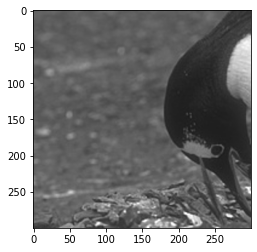

In [ ]:
# test_image = tf.keras.preprocessing.image.load_img("/content/drive/MyDrive/datas/train400/007.png")
# test_image = test_image.resize((300,300))
# input_arr = tf.keras.preprocessing.image.img_to_array(test_image)
# print(type(input_arr))
# test_image = np.divide(input_arr, 255.0)

plt.imshow(images[7])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


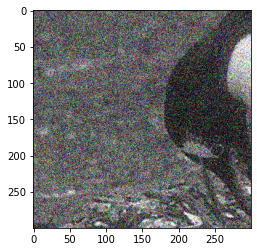

In [ ]:
# test_image_noisy = noisy(test_image)
plt.imshow(noisy_images[7])

#PREDICTING MODEL

Output for 1 Layer


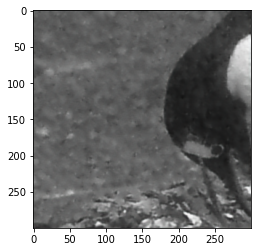

In [ ]:
reco = autoencoder1.predict(noisy_images[7][None])[0]
plt.imshow(reco)

output for 2 layers

In [ ]:
reco = autoencoder2.predict(noisy_images[7][None])[0]
plt.imshow(reco)

output 3 layers


In [ ]:
reco = autoencoder3.predict(noisy_images[7][None])[0]
plt.imshow(reco)

output 4 layers

In [ ]:
reco = autoencoder4.predict(noisy_images[7][None])[0]
plt.imshow(reco)

output for 5 layers

In [ ]:
reco = autoencoder5.predict(noisy_images[7][None])[0]
plt.imshow(reco)

PSNR

In [ ]:
from math import log10, sqrt
import cv2
  
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr


# value1 = PSNR(noisy_images[7], reco)
# print(value1)

62.273306384785116


PN


In [ ]:
input = layers.Input(shape=(300, 300, 3))

Model of PN


In [ ]:
# Encoder
def feature_extraction(input):
  # upper model
  x1 = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(input)

  return x1

In [ ]:
def feature_integration(concatenated):
  
  x3 = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(concatenated)

  return x3  

In [ ]:
def reconstruction(concatenated3):
  x = layers.Conv2DTranspose(16, (3, 3), activation="relu", padding="same")(concatenated3)
  x = layers.Conv2DTranspose(16, (3, 3), activation="relu",  padding="same", dilation_rate=(2,2))(x)
  out = layers.Conv2D(3, (1, 1), activation="sigmoid", padding="same")(x)
  return out

PN1

In [ ]:
model = feature_extraction(input)
for _ in range(1):
  model = feature_integration(model)
out_1 = reconstruction(model)

In [ ]:
import pickle
pn1 = Model(input, out_1)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
pn1.compile(optimizer=opt, loss="mse")
pn1.summary()

# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history1 = pn1.fit(x=train_images_noisy,y=train_images,epochs=50,batch_size=16,validation_data=(val_images_noisy, val_images))

# filename = 'pn_1_layer.sav'
# pickle.dump(history1.history, open(filename, 'wb'))

In [ ]:
with open('pn_layer_1_history', 'wb') as file_pi:
        pickle.dump(history1.history, file_pi)

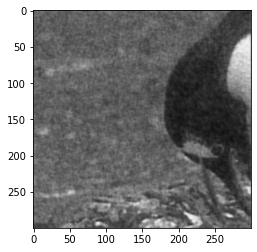

In [ ]:
reco = pn1.predict(noisy_images[7][None])[0]
plt.imshow(reco)

In [48]:
print(PSNR(noisy_images[7], reco))

62.23710547448981


PN 2

In [ ]:
model = feature_extraction(input)
for _ in range(2):
  model = feature_integration(model)
out_2 = reconstruction(model)

In [ ]:
import pickle
pn2 = Model(input, out_2)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
pn2.compile(optimizer=opt, loss="mse")
pn2.summary()

# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history2 = pn2.fit(x=train_images_noisy,y=train_images,epochs=50,batch_size=16,validation_data=(val_images_noisy, val_images))

# filename = 'pn_1_layer.sav'
# pickle.dump(history1.history, open(filename, 'wb'))

In [ ]:
with open('pn_layer_2_history', 'wb') as file_pi:
        pickle.dump(history2.history, file_pi)

In [ ]:
reco = pn2.predict(noisy_images[7][None])[0]
plt.imshow(reco)

In [ ]:
print(PSNR(noisy_images[7], reco))

PN3

In [ ]:
model = feature_extraction(input)
for _ in range(3):
  model = feature_integration(model)
out_3 = reconstruction(model)

In [ ]:
import pickle
pn3 = Model(input, out_3)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
pn3.compile(optimizer=opt, loss="mse")
pn3.summary()

# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history3 = pn3.fit(x=train_images_noisy,y=train_images,epochs=50,batch_size=16,validation_data=(val_images_noisy, val_images))

# filename = 'pn_1_layer.sav'
# pickle.dump(history1.history, open(filename, 'wb'))

In [ ]:
with open('pn_layer_3_history', 'wb') as file_pi:
        pickle.dump(history3.history, file_pi)

In [ ]:
reco = pn3.predict(noisy_images[7][None])[0]
plt.imshow(reco)

In [ ]:
print(PSNR(noisy_images[7], reco))

PN4

In [ ]:
model = feature_extraction(input)
for _ in range(4):
  model = feature_integration(model)
out_4 = reconstruction(model)

In [ ]:
import pickle
pn4 = Model(input, out_4)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
pn4.compile(optimizer=opt, loss="mse")
pn4.summary()

# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history4 = pn4.fit(x=train_images_noisy,y=train_images,epochs=50,batch_size=16,validation_data=(val_images_noisy, val_images))

# filename = 'pn_1_layer.sav'
# pickle.dump(history1.history, open(filename, 'wb'))

In [ ]:
with open('pn_layer_4_history', 'wb') as file_pi:
        pickle.dump(history4.history, file_pi)

In [ ]:
reco = pn4.predict(noisy_images[7][None])[0]
plt.imshow(reco)

In [ ]:
print(PSNR(noisy_images[7], reco))

PN5

In [ ]:
model = feature_extraction(input)
for _ in range(5):
  model = feature_integration(model)
out_5 = reconstruction(model)

In [ ]:
import pickle
pn5 = Model(input, out_5)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
pn5.compile(optimizer=opt, loss="mse")
pn5.summary()

# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history5 = pn5.fit(x=train_images_noisy,y=train_images,epochs=50,batch_size=16,validation_data=(val_images_noisy, val_images))

# filename = 'pn_1_layer.sav'
# pickle.dump(history1.history, open(filename, 'wb'))

In [ ]:
with open('pn_layer_5_history', 'wb') as file_pi:
        pickle.dump(history5.history, file_pi)

In [ ]:
reco = pn5.predict(noisy_images[7][None])[0]
plt.imshow(reco)

In [49]:
print(PSNR(noisy_images[7], reco))

62.23710547448981


DDN


In [10]:
input = layers.Input(shape=(300, 300, 3))

MODEL FOR DDN

In [11]:
def feature_extraction(input):
  # upper model
  x1 = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(input)
  x2 = layers.Conv2D(16, (3, 3), activation="relu", padding="same",dilation_rate=(2,2))(x1)

  # concat upper and lower model in feature extraction
  concatenated = tf.keras.layers.Concatenate(axis=-1)([x1, x2])

  return concatenated

In [12]:
def feature_integration(concatenated):
  conc_conv1 = layers.Conv2D(32, (1, 1), activation="sigmoid", padding="same")(concatenated)

  x4 = layers.Conv2D(16, (3, 3), activation="relu", padding="same",dilation_rate=(2,2))(conc_conv1)

  concatenated3 = tf.keras.layers.Concatenate(axis=-1)([conc_conv1, x4])

  print(concatenated3.shape)

  return concatenated3

In [13]:
def reconstruction(concatenated3):
  x = layers.Conv2DTranspose(16, (3, 3), activation="relu", padding="same")(concatenated3)
  x = layers.Conv2DTranspose(16, (3, 3), activation="relu",  padding="same", dilation_rate=(2,2))(x)
  out = layers.Conv2D(3, (1, 1), activation="sigmoid", padding="same")(x)
  return out

DDN1

In [14]:
model = feature_extraction(input)
for _ in range(1):
  model = feature_integration(model)
out_1 = reconstruction(model)

(None, 300, 300, 48)


In [17]:
import pickle
ddn1 = Model(input, out_1)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
ddn1.compile(optimizer=opt, loss="mse")
ddn1.summary()

# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history1 = ddn1.fit(x=train_images_noisy,y=train_images,epochs=50,batch_size=16,validation_data=(val_images_noisy, val_images))

# filename = 'pn_1_layer.sav'
# pickle.dump(history1.history, open(filename, 'wb'))

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 300, 300, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 300, 300, 16  2320        ['conv2d[0][0]']                 
                                )                                                           

In [18]:
with open('ddn_layer_1_history', 'wb') as file_pi:
        pickle.dump(history1.history, file_pi)

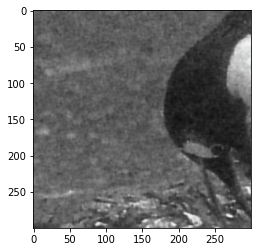

In [19]:
reco = ddn1.predict(noisy_images[7][None])[0]
plt.imshow(reco)

In [20]:
print(PSNR(noisy_images[7], reco))

62.3338766126613


DDN2

In [21]:
model = feature_extraction(input)
for _ in range(2):
  model = feature_integration(model)
out_2 = reconstruction(model)

(None, 300, 300, 48)
(None, 300, 300, 48)


In [22]:
import pickle
ddn2 = Model(input, out_2)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
ddn2.compile(optimizer=opt, loss="mse")
ddn2.summary()

# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history2 = ddn2.fit(x=train_images_noisy,y=train_images,epochs=50,batch_size=16,validation_data=(val_images_noisy, val_images))

# filename = 'pn_1_layer.sav'
# pickle.dump(history1.history, open(filename, 'wb'))

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 300, 300, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_6 (Conv2D)              (None, 300, 300, 16  2320        ['conv2d_5[0][0]']               
                                )                                                           

In [23]:
with open('ddn_layer_2_history', 'wb') as file_pi:
        pickle.dump(history2.history, file_pi)

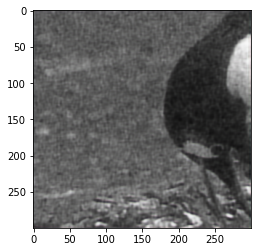

In [24]:
reco = ddn2.predict(noisy_images[7][None])[0]
plt.imshow(reco)

In [25]:
print(PSNR(noisy_images[7], reco))

62.30621701477675


DDN3

In [26]:
model = feature_extraction(input)
for _ in range(3):
  model = feature_integration(model)
out_3 = reconstruction(model)

(None, 300, 300, 48)
(None, 300, 300, 48)
(None, 300, 300, 48)


In [ ]:
import pickle
ddn3 = Model(input, out_3)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
ddn3.compile(optimizer=opt, loss="mse")
ddn3.summary()

# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history3 = ddn3.fit(x=train_images_noisy,y=train_images,epochs=50,batch_size=16,validation_data=(val_images_noisy, val_images))

# filename = 'pn_1_layer.sav'
# pickle.dump(history1.history, open(filename, 'wb'))

In [ ]:
with open('ddn_layer_3_history', 'wb') as file_pi:
        pickle.dump(history3.history, file_pi)

In [ ]:
reco = ddn3.predict(noisy_images[7][None])[0]
plt.imshow(reco)

In [ ]:
print(PSNR(noisy_images[7], reco))

DDN4

In [ ]:
model = feature_extraction(input)
for _ in range(4):
  model = feature_integration(model)
out_4 = reconstruction(model)

In [ ]:
import pickle
ddn4 = Model(input, out_4)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
ddn4.compile(optimizer=opt, loss="mse")
ddn4.summary()

# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history4 = ddn4.fit(x=train_images_noisy,y=train_images,epochs=50,batch_size=16,validation_data=(val_images_noisy, val_images))

# filename = 'pn_1_layer.sav'
# pickle.dump(history1.history, open(filename, 'wb'))

In [ ]:
with open('ddn_layer_4_history', 'wb') as file_pi:
        pickle.dump(history4.history, file_pi)

In [ ]:
reco = ddn4.predict(noisy_images[7][None])[0]
plt.imshow(reco)

In [ ]:
print(PSNR(noisy_images[7], reco))

DDN5

In [ ]:
model = feature_extraction(input)
for _ in range(5):
  model = feature_integration(model)
out_5 = reconstruction(model)

In [ ]:
import pickle
ddn5 = Model(input, out_5)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
ddn5.compile(optimizer=opt, loss="mse")
ddn5.summary()

# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history5 = ddn5.fit(x=train_images_noisy,y=train_images,epochs=50,batch_size=16,validation_data=(val_images_noisy, val_images))

# filename = 'pn_1_layer.sav'
# pickle.dump(history1.history, open(filename, 'wb'))

In [ ]:
with open('ddn_layer_5_history', 'wb') as file_pi:
        pickle.dump(history5.history, file_pi)

In [ ]:
reco = ddn5.predict(noisy_images[7][None])[0]
plt.imshow(reco)

In [ ]:
print(PSNR(noisy_images[7], reco))